In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### 1.) Loading the data

In [2]:
column_names = [
    "mpg",          # target (continuous)
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "model_year",
    "origin",
    "car_name"      # string label
]

In [3]:
# Load dataset
df = pd.read_csv(
    "auto-mpg.data", 
    delim_whitespace=True,   # split on spaces
    names=column_names, 
    na_values="?"            # turn '?' into NaN
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_32288\3487014623.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


### 2.)Exploratory data analysis

In [4]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [5]:
df.shape

(398, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


In [7]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


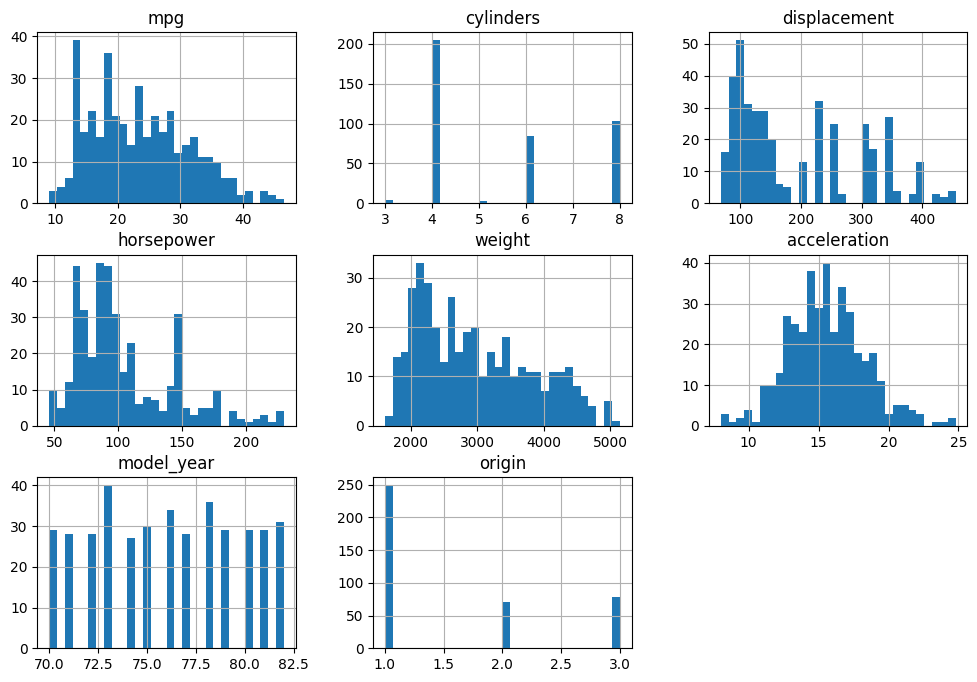

In [8]:
# Histograms
df.hist(bins=30, figsize=(12,8))
plt.show()

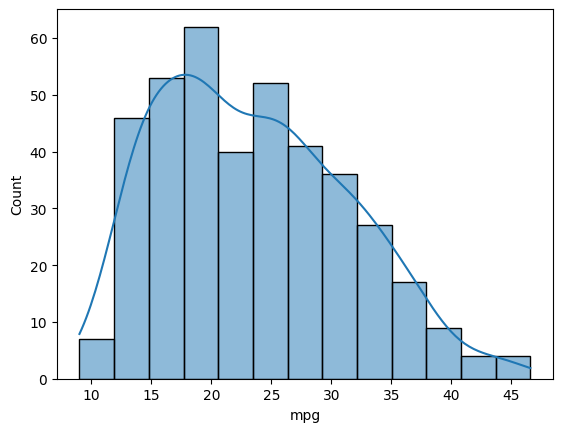

In [9]:
# KDE/Distribution plot for mpg
sns.histplot(df["mpg"], kde=True)
plt.show()

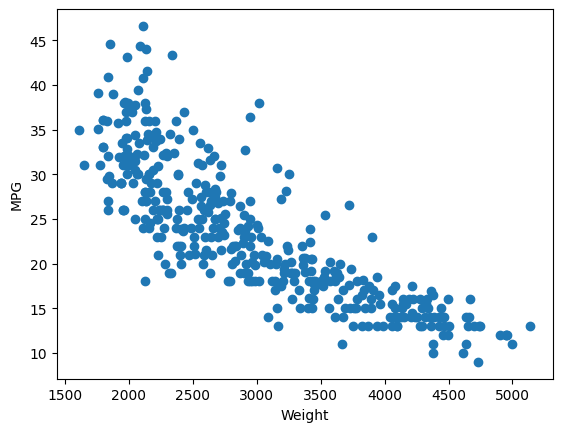

In [10]:
plt.scatter(df["weight"], df["mpg"])
plt.xlabel("Weight")
plt.ylabel("MPG")
plt.show()


In [11]:


fig = px.scatter_matrix(df, dimensions=["mpg","weight","horsepower","displacement"])
fig.show()


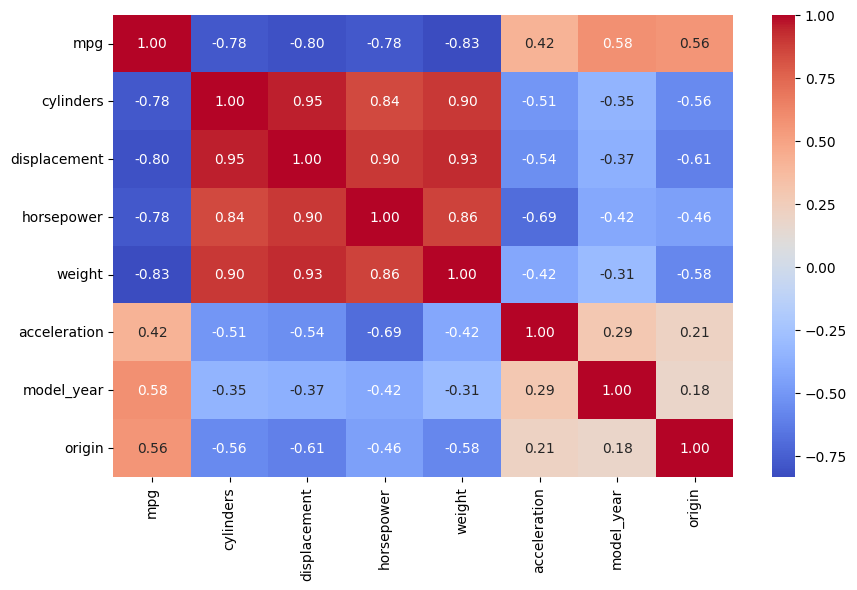

In [12]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


### 3.) Data preprocessing

In [13]:
# Convert 'horsepower' to numeric
df["horsepower"] = pd.to_numeric(df["horsepower"], errors="coerce")

In [14]:
# Drop rows with missing values
df = df.dropna()

In [15]:
# Drop irrelevant columns
df = df.drop(columns=["car_name"])


In [16]:
# Encode categorical 'origin' column
df = pd.get_dummies(df, columns=["origin"], drop_first=True)


In [17]:
X = df.drop(columns=["mpg"])
y = df["mpg"]

In [18]:
# Custom scaling
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)


In [19]:
# Custom train/test split
def train_test_split_custom(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    test_count = int(test_size * X.shape[0])
    test_idx = indices[:test_count]
    train_idx = indices[test_count:]
    return X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

X_train, X_test, y_train, y_test = train_test_split_custom(X_scaled, y)

In [20]:
def mse(y_true, y_pred):
    """Calculate Mean Squared Error."""
    return np.mean((y_true - y_pred) ** 2)


In [21]:
def mae(y_true, y_pred):
    """Calculate Mean Absolute Error."""
    return np.mean(np.abs(y_true - y_pred))


In [22]:
def r2_score(y_true, y_pred):
    """Calculate R-squared."""
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ss_res / ss_tot)


### 4.)Model training


In [23]:
class LinearRegressionScratch:
    """Linear Regression from scratch using Gradient Descent."""
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            # gradient descent
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


In [24]:
model = LinearRegressionScratch(lr=0.01, n_iters=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MSE:", mse(y_test, y_pred))
print("MAE:", mae(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MSE: 11.700450834919419
MAE: 2.5458492752418618
R²: 0.7726744443135682


### 5.)Model evaluation and Fine-tuning

In [25]:
# Learning rate
for lr in [0.001, 0.01, 0.05, 0.1]:
    model = LinearRegressionScratch(lr=lr, n_iters=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(lr, mse(y_test, y_pred))


0.001 82.3815790274241
0.01 11.700450834919419
0.05 10.88748818876076
0.1 10.743801543599753


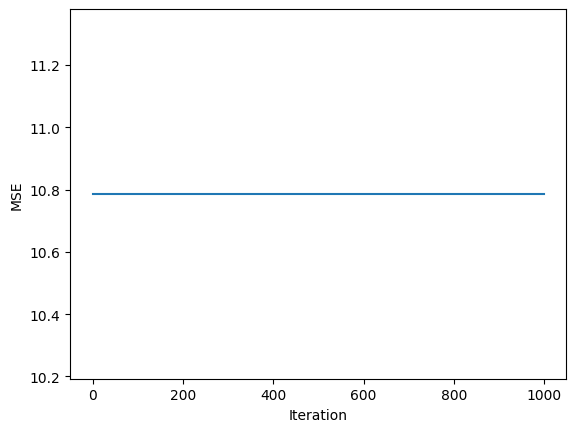

In [26]:
# Number of iterations
losses = []
for _ in range(model.n_iters):
    y_pred = np.dot(X_train, model.weights) + model.bias
    loss = mse(y_train, y_pred)
    losses.append(loss)
# Plot
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()
